In [10]:
import torch
import torchvision

import numpy as np
import string
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

In [11]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device
device = get_device()
device

'cpu'

# Load Data

In [9]:
transform = torchvision.transforms.Compose([torchvision.transforms.Grayscale(num_output_channels=1),
                                            torchvision.transforms.ToTensor()])

alphabet_set = torchvision.datasets.ImageFolder(root='./AlphabetDataset/',
                                                transform=transform)

print("Class names and corresponding labels:\n", alphabet_set.class_to_idx)
print("Total number of instances:", len(alphabet_set.targets))

Class names and corresponding labels:
 {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25}
Total number of instances: 372451


# View Data

label: A


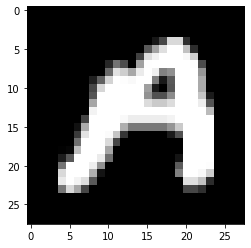

In [12]:
image, label = alphabet_set[8269] # label b/w 0, 26

alphabet_mapper = list(string.ascii_uppercase) # ['A', 'B',..., 'Z']

print('label:', alphabet_mapper[label])
plt.imshow(image.numpy()[0], cmap='gray')

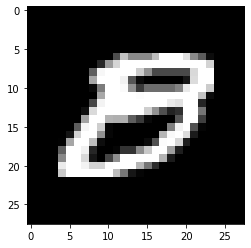

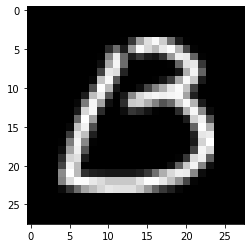

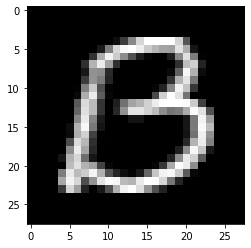

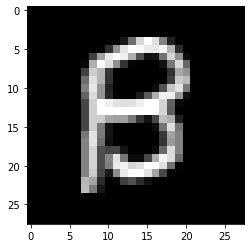

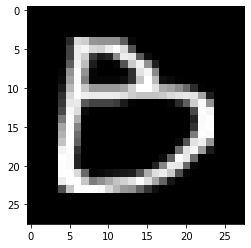

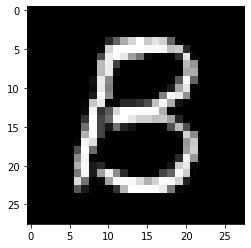

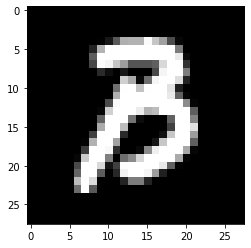

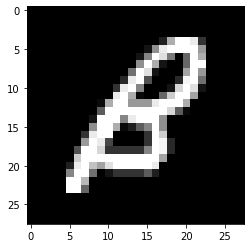

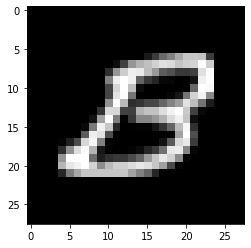

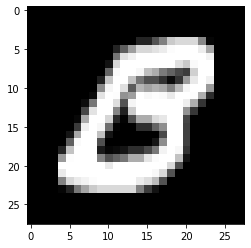

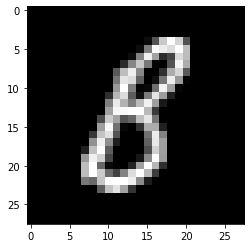

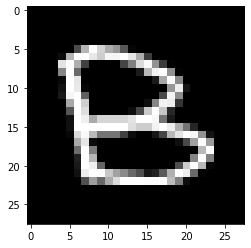

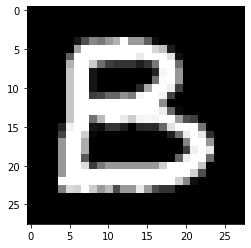

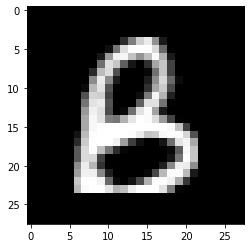

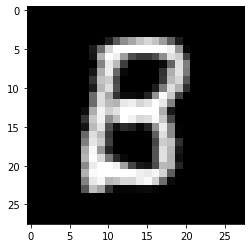

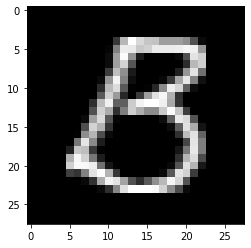

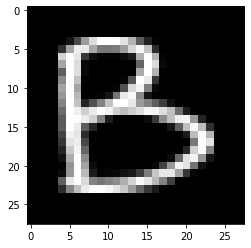

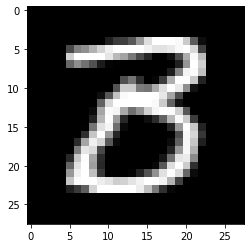

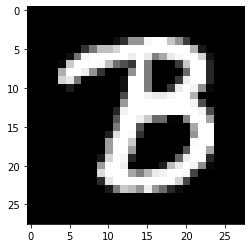

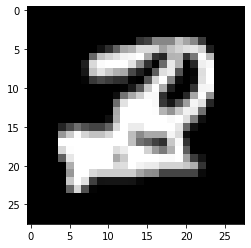

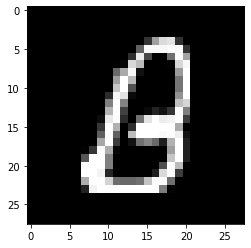

In [5]:
c = 0
for i in alphabet_set:
    image, label = i
    if alphabet_mapper[label] == 'B':
        c += 1
        plt.imshow(image[0], cmap='gray')
        plt.show()
    if c > 20:
        break

# the Network

In [13]:
class Network(torch.nn.Module):
    def __init__(self):
        
        super(Network, self).__init__()
        
        number_of_classes = 26
        
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=(2, 2))
        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.max_pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = torch.nn.Linear(in_features=16 * 5 * 5, out_features=120)
        self.fc2 = torch.nn.Linear(in_features=120, out_features=84)
        self.fc3 = torch.nn.Linear(in_features=84, out_features=number_of_classes)    
        
        self.relu = torch.nn.ReLU()
        self.dpt = torch.nn.Dropout(0.4) # 40% probability
    
    def forward(self, t):
        t = self.conv1(t) # 1 * 28 * 28 -> 6 * 28 * 28 
        t = self.relu(t)

        t = self.max_pool(t) # 6 * 14 * 14 
        
        t = self.conv2(t) # 16 * 10 * 10
        t = self.relu(t)

        t = self.max_pool(t) # 16 * 5 * 5
        
        t = self.dpt(t)
        
        t = t.reshape(-1, 16 * 5 * 5) # flatten in order to feed to the FC layers 

        t = self.fc1(t) # 400 -> 120
        t = self.relu(t)

        t = self.fc2(t) # 120 -> 84
        t = self.relu(t)
        
        t = self.fc3(t) # 84 -> 26 (number of classes)
        
        return t

# Train

In [22]:
batch_size = 1024
total_epochs = 2
learning_rate = 0.001


net = Network() #create Object
net.to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate) 
criterion = torch.nn.CrossEntropyLoss() # Defining the loss calculating method for our Network object. We use cross entropy loss.

train_loader = torch.utils.data.DataLoader(alphabet_set, batch_size=batch_size, shuffle=True) 

net = net.train()

for epoch in range(1, total_epochs + 1):

    batch_count = 0
    
    for batch in train_loader: #Get a Batch
        
        batch_count += 1

        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)

        preds = net(images) #Pass Batch; preds.shape -> (batch_size, number_of_classes)
        loss = criterion(preds, labels) # Calculate Loss

        optimizer.zero_grad()
        loss.backward() #Calculate Gradients
        optimizer.step() #Update Weights
        
        print(f'epoch: {epoch}/{total_epochs} | batch: {batch_count}/{len(train_loader)} | correct preds: {preds.argmax(dim=1).eq(labels).sum().item()}/{len(labels)}')

    print('Epoch:', epoch, '| Current loss:', loss.item())                                          

epoch: 1/2 | batch: 1/364 | correct preds: 73/1024
epoch: 1/2 | batch: 2/364 | correct preds: 63/1024
epoch: 1/2 | batch: 3/364 | correct preds: 58/1024
epoch: 1/2 | batch: 4/364 | correct preds: 93/1024
epoch: 1/2 | batch: 5/364 | correct preds: 134/1024
epoch: 1/2 | batch: 6/364 | correct preds: 166/1024
epoch: 1/2 | batch: 7/364 | correct preds: 164/1024
epoch: 1/2 | batch: 8/364 | correct preds: 168/1024
epoch: 1/2 | batch: 9/364 | correct preds: 159/1024
epoch: 1/2 | batch: 10/364 | correct preds: 160/1024
epoch: 1/2 | batch: 11/364 | correct preds: 159/1024
epoch: 1/2 | batch: 12/364 | correct preds: 162/1024
epoch: 1/2 | batch: 13/364 | correct preds: 140/1024
epoch: 1/2 | batch: 14/364 | correct preds: 169/1024
epoch: 1/2 | batch: 15/364 | correct preds: 155/1024
epoch: 1/2 | batch: 16/364 | correct preds: 176/1024
epoch: 1/2 | batch: 17/364 | correct preds: 163/1024
epoch: 1/2 | batch: 18/364 | correct preds: 154/1024
epoch: 1/2 | batch: 19/364 | correct preds: 163/1024
epoch:

epoch: 1/2 | batch: 155/364 | correct preds: 878/1024
epoch: 1/2 | batch: 156/364 | correct preds: 886/1024
epoch: 1/2 | batch: 157/364 | correct preds: 886/1024
epoch: 1/2 | batch: 158/364 | correct preds: 885/1024
epoch: 1/2 | batch: 159/364 | correct preds: 869/1024
epoch: 1/2 | batch: 160/364 | correct preds: 879/1024
epoch: 1/2 | batch: 161/364 | correct preds: 890/1024
epoch: 1/2 | batch: 162/364 | correct preds: 893/1024
epoch: 1/2 | batch: 163/364 | correct preds: 887/1024
epoch: 1/2 | batch: 164/364 | correct preds: 894/1024
epoch: 1/2 | batch: 165/364 | correct preds: 896/1024
epoch: 1/2 | batch: 166/364 | correct preds: 892/1024
epoch: 1/2 | batch: 167/364 | correct preds: 887/1024
epoch: 1/2 | batch: 168/364 | correct preds: 887/1024
epoch: 1/2 | batch: 169/364 | correct preds: 872/1024
epoch: 1/2 | batch: 170/364 | correct preds: 893/1024
epoch: 1/2 | batch: 171/364 | correct preds: 904/1024
epoch: 1/2 | batch: 172/364 | correct preds: 898/1024
epoch: 1/2 | batch: 173/364 

epoch: 1/2 | batch: 307/364 | correct preds: 943/1024
epoch: 1/2 | batch: 308/364 | correct preds: 963/1024
epoch: 1/2 | batch: 309/364 | correct preds: 942/1024
epoch: 1/2 | batch: 310/364 | correct preds: 943/1024
epoch: 1/2 | batch: 311/364 | correct preds: 946/1024
epoch: 1/2 | batch: 312/364 | correct preds: 944/1024
epoch: 1/2 | batch: 313/364 | correct preds: 946/1024
epoch: 1/2 | batch: 314/364 | correct preds: 950/1024
epoch: 1/2 | batch: 315/364 | correct preds: 934/1024
epoch: 1/2 | batch: 316/364 | correct preds: 945/1024
epoch: 1/2 | batch: 317/364 | correct preds: 933/1024
epoch: 1/2 | batch: 318/364 | correct preds: 945/1024
epoch: 1/2 | batch: 319/364 | correct preds: 948/1024
epoch: 1/2 | batch: 320/364 | correct preds: 953/1024
epoch: 1/2 | batch: 321/364 | correct preds: 950/1024
epoch: 1/2 | batch: 322/364 | correct preds: 942/1024
epoch: 1/2 | batch: 323/364 | correct preds: 951/1024
epoch: 1/2 | batch: 324/364 | correct preds: 942/1024
epoch: 1/2 | batch: 325/364 

epoch: 2/2 | batch: 96/364 | correct preds: 958/1024
epoch: 2/2 | batch: 97/364 | correct preds: 975/1024
epoch: 2/2 | batch: 98/364 | correct preds: 952/1024
epoch: 2/2 | batch: 99/364 | correct preds: 961/1024
epoch: 2/2 | batch: 100/364 | correct preds: 961/1024
epoch: 2/2 | batch: 101/364 | correct preds: 978/1024
epoch: 2/2 | batch: 102/364 | correct preds: 961/1024
epoch: 2/2 | batch: 103/364 | correct preds: 959/1024
epoch: 2/2 | batch: 104/364 | correct preds: 959/1024
epoch: 2/2 | batch: 105/364 | correct preds: 958/1024
epoch: 2/2 | batch: 106/364 | correct preds: 966/1024
epoch: 2/2 | batch: 107/364 | correct preds: 966/1024
epoch: 2/2 | batch: 108/364 | correct preds: 963/1024
epoch: 2/2 | batch: 109/364 | correct preds: 963/1024
epoch: 2/2 | batch: 110/364 | correct preds: 948/1024
epoch: 2/2 | batch: 111/364 | correct preds: 962/1024
epoch: 2/2 | batch: 112/364 | correct preds: 973/1024
epoch: 2/2 | batch: 113/364 | correct preds: 975/1024
epoch: 2/2 | batch: 114/364 | co

epoch: 2/2 | batch: 248/364 | correct preds: 975/1024
epoch: 2/2 | batch: 249/364 | correct preds: 976/1024
epoch: 2/2 | batch: 250/364 | correct preds: 972/1024
epoch: 2/2 | batch: 251/364 | correct preds: 979/1024
epoch: 2/2 | batch: 252/364 | correct preds: 972/1024
epoch: 2/2 | batch: 253/364 | correct preds: 976/1024
epoch: 2/2 | batch: 254/364 | correct preds: 976/1024
epoch: 2/2 | batch: 255/364 | correct preds: 979/1024
epoch: 2/2 | batch: 256/364 | correct preds: 968/1024
epoch: 2/2 | batch: 257/364 | correct preds: 967/1024
epoch: 2/2 | batch: 258/364 | correct preds: 995/1024
epoch: 2/2 | batch: 259/364 | correct preds: 971/1024
epoch: 2/2 | batch: 260/364 | correct preds: 976/1024
epoch: 2/2 | batch: 261/364 | correct preds: 974/1024
epoch: 2/2 | batch: 262/364 | correct preds: 978/1024
epoch: 2/2 | batch: 263/364 | correct preds: 980/1024
epoch: 2/2 | batch: 264/364 | correct preds: 990/1024
epoch: 2/2 | batch: 265/364 | correct preds: 978/1024
epoch: 2/2 | batch: 266/364 

# Save the model

In [23]:
path = "./saved_models/my_cnn_model.pt" 
torch.save(net.state_dict(), path)

# 10 Fold Cross Validation

In [6]:
def ten_fold_cv(the_dataset, total_epochs, learning_rate, batch_size):
    
    kf = KFold(n_splits = 10, shuffle=True)

    total_accuracy = 0
    fold = 1
    for train_index, test_index in kf.split(the_dataset): # each fold
        train_set = torch.utils.data.Subset(the_dataset, train_index) 
        test_set = torch.utils.data.Subset(the_dataset, test_index) 

        train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

        net = Network() # a new object is created for each fold
        net = net.to(device)
        optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate) # specific to this net object of this fold 
        criterion = torch.nn.CrossEntropyLoss() # Defining the loss calculating method for our Network object. We use cross entropy loss.

        for epoch in range(total_epochs): 
            for batch in train_loader: # each Batch (0 to 54000/100)
                images, labels = batch
                images = images.to(device)
                labels = labels.to(device)

                preds = net(images) # Pass Batch (Forward pass)
                loss = criterion(preds, labels) 

                print('epoch:', epoch, 'loss:', loss.item(), 'correct predictions:', preds.argmax(dim=1).eq(labels).sum().item(), '/', len(labels), 'fold:', fold)

                optimizer.zero_grad()
                loss.backward() # Calculate Gradients
                optimizer.step() # Update Weights

            print('fold: ', fold, '/', '10 epoch:', epoch+1,  '/', total_epochs, 'loss:', loss.item())

        #testing
        test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)
        total_correct_predictions = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = net(images)
            total_correct_predictions += preds.argmax(dim=1).eq(labels).sum().item()

        accuracy = total_correct_predictions / len(test_set)
        
        print('fold: ', fold, '/', '10', 'correct predictions: ', total_correct_predictions, '/', len(test_set), 'accuracy:', accuracy)
        print()

        total_accuracy += accuracy

        fold += 1


    final_accuracy = total_accuracy / 10
    print('final result:')
    print('accuracy:', final_accuracy)
    return final_accuracy

In [11]:
ten_fold_cv(the_dataset=alphabet_set, total_epochs=2, learning_rate=0.001, batch_size=1024)

epoch: 0 loss: 3.2649986743927 correct predictions: 26 / 1000 fold: 1
epoch: 0 loss: 3.250626564025879 correct predictions: 25 / 1000 fold: 1
epoch: 0 loss: 3.2372817993164062 correct predictions: 93 / 1000 fold: 1
epoch: 0 loss: 3.2323715686798096 correct predictions: 158 / 1000 fold: 1
epoch: 0 loss: 3.21946120262146 correct predictions: 208 / 1000 fold: 1
epoch: 0 loss: 3.2068517208099365 correct predictions: 163 / 1000 fold: 1
epoch: 0 loss: 3.185987710952759 correct predictions: 138 / 1000 fold: 1
epoch: 0 loss: 3.155918836593628 correct predictions: 154 / 1000 fold: 1
epoch: 0 loss: 3.1199240684509277 correct predictions: 168 / 1000 fold: 1
epoch: 0 loss: 3.089585542678833 correct predictions: 150 / 1000 fold: 1
epoch: 0 loss: 3.0249035358428955 correct predictions: 157 / 1000 fold: 1
epoch: 0 loss: 2.997222661972046 correct predictions: 143 / 1000 fold: 1
epoch: 0 loss: 2.917900562286377 correct predictions: 171 / 1000 fold: 1
epoch: 0 loss: 2.9754157066345215 correct prediction

epoch: 0 loss: 0.7792159914970398 correct predictions: 756 / 1000 fold: 1
epoch: 0 loss: 0.7971436381340027 correct predictions: 760 / 1000 fold: 1
epoch: 0 loss: 0.8316102027893066 correct predictions: 737 / 1000 fold: 1
epoch: 0 loss: 0.7945255637168884 correct predictions: 767 / 1000 fold: 1
epoch: 0 loss: 0.7181834578514099 correct predictions: 786 / 1000 fold: 1
epoch: 0 loss: 0.6794947385787964 correct predictions: 805 / 1000 fold: 1
epoch: 0 loss: 0.6964837312698364 correct predictions: 793 / 1000 fold: 1
epoch: 0 loss: 0.6841052770614624 correct predictions: 804 / 1000 fold: 1
epoch: 0 loss: 0.6385647058486938 correct predictions: 822 / 1000 fold: 1
epoch: 0 loss: 0.6624367833137512 correct predictions: 797 / 1000 fold: 1
epoch: 0 loss: 0.659067690372467 correct predictions: 803 / 1000 fold: 1
epoch: 0 loss: 0.671582818031311 correct predictions: 796 / 1000 fold: 1
epoch: 0 loss: 0.5957987308502197 correct predictions: 832 / 1000 fold: 1
epoch: 0 loss: 0.6595895290374756 correc

epoch: 0 loss: 0.39345407485961914 correct predictions: 884 / 1000 fold: 1
epoch: 0 loss: 0.41431280970573425 correct predictions: 879 / 1000 fold: 1
epoch: 0 loss: 0.36207666993141174 correct predictions: 898 / 1000 fold: 1
epoch: 0 loss: 0.3867821991443634 correct predictions: 879 / 1000 fold: 1
epoch: 0 loss: 0.3690057098865509 correct predictions: 902 / 1000 fold: 1
epoch: 0 loss: 0.3430362045764923 correct predictions: 901 / 1000 fold: 1
epoch: 0 loss: 0.3372696042060852 correct predictions: 905 / 1000 fold: 1
epoch: 0 loss: 0.3791998624801636 correct predictions: 886 / 1000 fold: 1
epoch: 0 loss: 0.3636975884437561 correct predictions: 896 / 1000 fold: 1
epoch: 0 loss: 0.3579213619232178 correct predictions: 898 / 1000 fold: 1
epoch: 0 loss: 0.38825303316116333 correct predictions: 885 / 1000 fold: 1
epoch: 0 loss: 0.37315982580184937 correct predictions: 893 / 1000 fold: 1
epoch: 0 loss: 0.44027650356292725 correct predictions: 868 / 1000 fold: 1
epoch: 0 loss: 0.423225671052932

epoch: 1 loss: 0.2956918776035309 correct predictions: 918 / 1000 fold: 1
epoch: 1 loss: 0.2588757574558258 correct predictions: 931 / 1000 fold: 1
epoch: 1 loss: 0.27627676725387573 correct predictions: 920 / 1000 fold: 1
epoch: 1 loss: 0.32935938239097595 correct predictions: 915 / 1000 fold: 1
epoch: 1 loss: 0.2581925094127655 correct predictions: 913 / 1000 fold: 1
epoch: 1 loss: 0.2932271659374237 correct predictions: 917 / 1000 fold: 1
epoch: 1 loss: 0.3036183714866638 correct predictions: 910 / 1000 fold: 1
epoch: 1 loss: 0.2756659686565399 correct predictions: 923 / 1000 fold: 1
epoch: 1 loss: 0.31032735109329224 correct predictions: 913 / 1000 fold: 1
epoch: 1 loss: 0.23104356229305267 correct predictions: 939 / 1000 fold: 1
epoch: 1 loss: 0.26859331130981445 correct predictions: 911 / 1000 fold: 1
epoch: 1 loss: 0.24952562153339386 correct predictions: 916 / 1000 fold: 1
epoch: 1 loss: 0.2614000737667084 correct predictions: 926 / 1000 fold: 1
epoch: 1 loss: 0.272594898939132

epoch: 1 loss: 0.18829771876335144 correct predictions: 949 / 1000 fold: 1
epoch: 1 loss: 0.2231588214635849 correct predictions: 940 / 1000 fold: 1
epoch: 1 loss: 0.15014590322971344 correct predictions: 958 / 1000 fold: 1
epoch: 1 loss: 0.18158642947673798 correct predictions: 945 / 1000 fold: 1
epoch: 1 loss: 0.2555501461029053 correct predictions: 926 / 1000 fold: 1
epoch: 1 loss: 0.21449607610702515 correct predictions: 938 / 1000 fold: 1
epoch: 1 loss: 0.19688549637794495 correct predictions: 937 / 1000 fold: 1
epoch: 1 loss: 0.25036805868148804 correct predictions: 921 / 1000 fold: 1
epoch: 1 loss: 0.22617729008197784 correct predictions: 931 / 1000 fold: 1
epoch: 1 loss: 0.20413747429847717 correct predictions: 941 / 1000 fold: 1
epoch: 1 loss: 0.19980797171592712 correct predictions: 942 / 1000 fold: 1
epoch: 1 loss: 0.2090362310409546 correct predictions: 933 / 1000 fold: 1
epoch: 1 loss: 0.19370462000370026 correct predictions: 943 / 1000 fold: 1
epoch: 1 loss: 0.23331445455

epoch: 1 loss: 0.1872229129076004 correct predictions: 942 / 1000 fold: 1
epoch: 1 loss: 0.1984419822692871 correct predictions: 937 / 1000 fold: 1
epoch: 1 loss: 0.17946110665798187 correct predictions: 944 / 1000 fold: 1
epoch: 1 loss: 0.17551720142364502 correct predictions: 954 / 1000 fold: 1
epoch: 1 loss: 0.18544211983680725 correct predictions: 946 / 1000 fold: 1
epoch: 1 loss: 0.17668356001377106 correct predictions: 952 / 1000 fold: 1
epoch: 1 loss: 0.20598983764648438 correct predictions: 942 / 1000 fold: 1
epoch: 1 loss: 0.19167029857635498 correct predictions: 941 / 1000 fold: 1
epoch: 1 loss: 0.17372171580791473 correct predictions: 947 / 1000 fold: 1
epoch: 1 loss: 0.19850969314575195 correct predictions: 936 / 1000 fold: 1
epoch: 1 loss: 0.17039042711257935 correct predictions: 953 / 1000 fold: 1
epoch: 1 loss: 0.21199509501457214 correct predictions: 940 / 1000 fold: 1
epoch: 1 loss: 0.20418162643909454 correct predictions: 935 / 1000 fold: 1
epoch: 1 loss: 0.1806699037

epoch: 1 loss: 0.16792218387126923 correct predictions: 947 / 1000 fold: 1
epoch: 1 loss: 0.14515608549118042 correct predictions: 955 / 1000 fold: 1
epoch: 1 loss: 0.1586446464061737 correct predictions: 953 / 1000 fold: 1
epoch: 1 loss: 0.17233312129974365 correct predictions: 287 / 300 fold: 1
fold:  1 / 10 epoch: 2 / 2 loss: 0.17233312129974365
fold:  1 / 10 correct predictions:  35239 / 37034 accuracy: 0.9515310255440946

epoch: 0 loss: 3.265591621398926 correct predictions: 20 / 1000 fold: 2
epoch: 0 loss: 3.254678249359131 correct predictions: 19 / 1000 fold: 2
epoch: 0 loss: 3.239849090576172 correct predictions: 56 / 1000 fold: 2
epoch: 0 loss: 3.2275519371032715 correct predictions: 150 / 1000 fold: 2
epoch: 0 loss: 3.2020435333251953 correct predictions: 160 / 1000 fold: 2
epoch: 0 loss: 3.1678075790405273 correct predictions: 170 / 1000 fold: 2
epoch: 0 loss: 3.131507635116577 correct predictions: 144 / 1000 fold: 2
epoch: 0 loss: 3.0696136951446533 correct predictions: 164

epoch: 0 loss: 0.8676032423973083 correct predictions: 750 / 1000 fold: 2
epoch: 0 loss: 0.8983839154243469 correct predictions: 732 / 1000 fold: 2
epoch: 0 loss: 0.8434516191482544 correct predictions: 750 / 1000 fold: 2
epoch: 0 loss: 0.8932785391807556 correct predictions: 723 / 1000 fold: 2
epoch: 0 loss: 0.8227723836898804 correct predictions: 754 / 1000 fold: 2
epoch: 0 loss: 0.7650505304336548 correct predictions: 765 / 1000 fold: 2
epoch: 0 loss: 0.8681432604789734 correct predictions: 749 / 1000 fold: 2
epoch: 0 loss: 0.8686078786849976 correct predictions: 744 / 1000 fold: 2
epoch: 0 loss: 0.8702796101570129 correct predictions: 736 / 1000 fold: 2
epoch: 0 loss: 0.8036272525787354 correct predictions: 759 / 1000 fold: 2
epoch: 0 loss: 0.8313987255096436 correct predictions: 756 / 1000 fold: 2
epoch: 0 loss: 0.7837958931922913 correct predictions: 766 / 1000 fold: 2
epoch: 0 loss: 0.8320745229721069 correct predictions: 756 / 1000 fold: 2
epoch: 0 loss: 0.8199624419212341 corr

epoch: 0 loss: 0.4375607371330261 correct predictions: 877 / 1000 fold: 2
epoch: 0 loss: 0.41138988733291626 correct predictions: 888 / 1000 fold: 2
epoch: 0 loss: 0.447630912065506 correct predictions: 868 / 1000 fold: 2
epoch: 0 loss: 0.3715541660785675 correct predictions: 892 / 1000 fold: 2
epoch: 0 loss: 0.44559457898139954 correct predictions: 878 / 1000 fold: 2
epoch: 0 loss: 0.3572726845741272 correct predictions: 888 / 1000 fold: 2
epoch: 0 loss: 0.42180120944976807 correct predictions: 878 / 1000 fold: 2
epoch: 0 loss: 0.35789754986763 correct predictions: 893 / 1000 fold: 2
epoch: 0 loss: 0.36803022027015686 correct predictions: 889 / 1000 fold: 2
epoch: 0 loss: 0.3768395185470581 correct predictions: 893 / 1000 fold: 2
epoch: 0 loss: 0.3829515278339386 correct predictions: 886 / 1000 fold: 2
epoch: 0 loss: 0.3685632348060608 correct predictions: 900 / 1000 fold: 2
epoch: 0 loss: 0.3753436207771301 correct predictions: 907 / 1000 fold: 2
epoch: 0 loss: 0.40019506216049194 co

epoch: 0 loss: 0.3110303282737732 correct predictions: 912 / 1000 fold: 2
epoch: 0 loss: 0.31173160672187805 correct predictions: 913 / 1000 fold: 2
epoch: 0 loss: 0.3062376081943512 correct predictions: 921 / 1000 fold: 2
epoch: 0 loss: 0.2866060733795166 correct predictions: 912 / 1000 fold: 2
epoch: 0 loss: 0.23998527228832245 correct predictions: 926 / 1000 fold: 2
epoch: 0 loss: 0.31181541085243225 correct predictions: 270 / 300 fold: 2
fold:  2 / 10 epoch: 1 / 2 loss: 0.31181541085243225
epoch: 1 loss: 0.27765125036239624 correct predictions: 919 / 1000 fold: 2
epoch: 1 loss: 0.30560436844825745 correct predictions: 917 / 1000 fold: 2
epoch: 1 loss: 0.232584610581398 correct predictions: 932 / 1000 fold: 2
epoch: 1 loss: 0.24379102885723114 correct predictions: 925 / 1000 fold: 2
epoch: 1 loss: 0.24402117729187012 correct predictions: 937 / 1000 fold: 2
epoch: 1 loss: 0.2907622158527374 correct predictions: 913 / 1000 fold: 2
epoch: 1 loss: 0.2979376018047333 correct predictions:

epoch: 1 loss: 0.2130744308233261 correct predictions: 932 / 1000 fold: 2
epoch: 1 loss: 0.21604186296463013 correct predictions: 931 / 1000 fold: 2
epoch: 1 loss: 0.24117200076580048 correct predictions: 928 / 1000 fold: 2
epoch: 1 loss: 0.19848507642745972 correct predictions: 948 / 1000 fold: 2
epoch: 1 loss: 0.2569945156574249 correct predictions: 924 / 1000 fold: 2
epoch: 1 loss: 0.23650261759757996 correct predictions: 933 / 1000 fold: 2
epoch: 1 loss: 0.22159861028194427 correct predictions: 940 / 1000 fold: 2
epoch: 1 loss: 0.21337983012199402 correct predictions: 940 / 1000 fold: 2
epoch: 1 loss: 0.20329409837722778 correct predictions: 939 / 1000 fold: 2
epoch: 1 loss: 0.20815956592559814 correct predictions: 937 / 1000 fold: 2
epoch: 1 loss: 0.2175084501504898 correct predictions: 929 / 1000 fold: 2
epoch: 1 loss: 0.1914186328649521 correct predictions: 946 / 1000 fold: 2
epoch: 1 loss: 0.20650871098041534 correct predictions: 940 / 1000 fold: 2
epoch: 1 loss: 0.244433835148

epoch: 1 loss: 0.1937517374753952 correct predictions: 943 / 1000 fold: 2
epoch: 1 loss: 0.15730027854442596 correct predictions: 946 / 1000 fold: 2
epoch: 1 loss: 0.17895697057247162 correct predictions: 944 / 1000 fold: 2
epoch: 1 loss: 0.18490560352802277 correct predictions: 947 / 1000 fold: 2
epoch: 1 loss: 0.16688290238380432 correct predictions: 948 / 1000 fold: 2
epoch: 1 loss: 0.21105672419071198 correct predictions: 943 / 1000 fold: 2
epoch: 1 loss: 0.21992719173431396 correct predictions: 935 / 1000 fold: 2
epoch: 1 loss: 0.16494230926036835 correct predictions: 945 / 1000 fold: 2
epoch: 1 loss: 0.1854301244020462 correct predictions: 942 / 1000 fold: 2
epoch: 1 loss: 0.18316850066184998 correct predictions: 951 / 1000 fold: 2
epoch: 1 loss: 0.1678972691297531 correct predictions: 949 / 1000 fold: 2
epoch: 1 loss: 0.2351934313774109 correct predictions: 932 / 1000 fold: 2
epoch: 1 loss: 0.173177570104599 correct predictions: 955 / 1000 fold: 2
epoch: 1 loss: 0.20658257603645

epoch: 1 loss: 0.17415809631347656 correct predictions: 957 / 1000 fold: 2
epoch: 1 loss: 0.20560336112976074 correct predictions: 936 / 1000 fold: 2
epoch: 1 loss: 0.1380232572555542 correct predictions: 956 / 1000 fold: 2
epoch: 1 loss: 0.16117647290229797 correct predictions: 953 / 1000 fold: 2
epoch: 1 loss: 0.1538347750902176 correct predictions: 956 / 1000 fold: 2
epoch: 1 loss: 0.13582170009613037 correct predictions: 958 / 1000 fold: 2
epoch: 1 loss: 0.1469039022922516 correct predictions: 958 / 1000 fold: 2
epoch: 1 loss: 0.18587203323841095 correct predictions: 951 / 1000 fold: 2
epoch: 1 loss: 0.16305182874202728 correct predictions: 955 / 1000 fold: 2
epoch: 1 loss: 0.18255646526813507 correct predictions: 288 / 300 fold: 2
fold:  2 / 10 epoch: 2 / 2 loss: 0.18255646526813507
fold:  2 / 10 correct predictions:  35234 / 37034 accuracy: 0.9513960144731868

epoch: 0 loss: 3.2570486068725586 correct predictions: 16 / 1000 fold: 3
epoch: 0 loss: 3.2397913932800293 correct predic

epoch: 0 loss: 0.7872211337089539 correct predictions: 773 / 1000 fold: 3
epoch: 0 loss: 0.7164182662963867 correct predictions: 798 / 1000 fold: 3
epoch: 0 loss: 0.7419703006744385 correct predictions: 760 / 1000 fold: 3
epoch: 0 loss: 0.7063645124435425 correct predictions: 781 / 1000 fold: 3
epoch: 0 loss: 0.7615786790847778 correct predictions: 772 / 1000 fold: 3
epoch: 0 loss: 0.7750949859619141 correct predictions: 761 / 1000 fold: 3
epoch: 0 loss: 0.7523813247680664 correct predictions: 779 / 1000 fold: 3
epoch: 0 loss: 0.789381206035614 correct predictions: 766 / 1000 fold: 3
epoch: 0 loss: 0.7737734913825989 correct predictions: 768 / 1000 fold: 3
epoch: 0 loss: 0.7685003876686096 correct predictions: 781 / 1000 fold: 3
epoch: 0 loss: 0.6948670148849487 correct predictions: 807 / 1000 fold: 3
epoch: 0 loss: 0.7347244024276733 correct predictions: 798 / 1000 fold: 3
epoch: 0 loss: 0.7378475666046143 correct predictions: 775 / 1000 fold: 3
epoch: 0 loss: 0.63836270570755 correct

epoch: 0 loss: 0.445113867521286 correct predictions: 876 / 1000 fold: 3
epoch: 0 loss: 0.38349592685699463 correct predictions: 883 / 1000 fold: 3
epoch: 0 loss: 0.35774528980255127 correct predictions: 893 / 1000 fold: 3
epoch: 0 loss: 0.42514732480049133 correct predictions: 879 / 1000 fold: 3
epoch: 0 loss: 0.4011426270008087 correct predictions: 882 / 1000 fold: 3
epoch: 0 loss: 0.3564879894256592 correct predictions: 900 / 1000 fold: 3
epoch: 0 loss: 0.40361836552619934 correct predictions: 886 / 1000 fold: 3
epoch: 0 loss: 0.3609720468521118 correct predictions: 899 / 1000 fold: 3
epoch: 0 loss: 0.3997674584388733 correct predictions: 886 / 1000 fold: 3
epoch: 0 loss: 0.3757941722869873 correct predictions: 888 / 1000 fold: 3
epoch: 0 loss: 0.4241195619106293 correct predictions: 876 / 1000 fold: 3
epoch: 0 loss: 0.3223589360713959 correct predictions: 903 / 1000 fold: 3
epoch: 0 loss: 0.4123800992965698 correct predictions: 867 / 1000 fold: 3
epoch: 0 loss: 0.36505526304244995 

epoch: 0 loss: 0.2648397386074066 correct predictions: 927 / 1000 fold: 3
epoch: 0 loss: 0.27500268816947937 correct predictions: 917 / 1000 fold: 3
epoch: 0 loss: 0.2615334093570709 correct predictions: 919 / 1000 fold: 3
epoch: 0 loss: 0.30675777792930603 correct predictions: 908 / 1000 fold: 3
epoch: 0 loss: 0.2808835208415985 correct predictions: 912 / 1000 fold: 3
epoch: 0 loss: 0.2688208818435669 correct predictions: 915 / 1000 fold: 3
epoch: 0 loss: 0.246144637465477 correct predictions: 922 / 1000 fold: 3
epoch: 0 loss: 0.3431272804737091 correct predictions: 901 / 1000 fold: 3
epoch: 0 loss: 0.2696038484573364 correct predictions: 917 / 1000 fold: 3
epoch: 0 loss: 0.25588080286979675 correct predictions: 924 / 1000 fold: 3
epoch: 0 loss: 0.20575538277626038 correct predictions: 946 / 1000 fold: 3
epoch: 0 loss: 0.3578323721885681 correct predictions: 269 / 300 fold: 3
fold:  3 / 10 epoch: 1 / 2 loss: 0.3578323721885681
epoch: 1 loss: 0.29491865634918213 correct predictions: 91

epoch: 1 loss: 0.2092408984899521 correct predictions: 939 / 1000 fold: 3
epoch: 1 loss: 0.22646108269691467 correct predictions: 929 / 1000 fold: 3
epoch: 1 loss: 0.22299815714359283 correct predictions: 941 / 1000 fold: 3
epoch: 1 loss: 0.255207359790802 correct predictions: 938 / 1000 fold: 3
epoch: 1 loss: 0.22320404648780823 correct predictions: 928 / 1000 fold: 3
epoch: 1 loss: 0.22244669497013092 correct predictions: 941 / 1000 fold: 3
epoch: 1 loss: 0.23612141609191895 correct predictions: 930 / 1000 fold: 3
epoch: 1 loss: 0.20804934203624725 correct predictions: 941 / 1000 fold: 3
epoch: 1 loss: 0.21997281908988953 correct predictions: 941 / 1000 fold: 3
epoch: 1 loss: 0.2111651599407196 correct predictions: 943 / 1000 fold: 3
epoch: 1 loss: 0.2065785676240921 correct predictions: 939 / 1000 fold: 3
epoch: 1 loss: 0.22850100696086884 correct predictions: 934 / 1000 fold: 3
epoch: 1 loss: 0.20151038467884064 correct predictions: 941 / 1000 fold: 3
epoch: 1 loss: 0.1990856081247

epoch: 1 loss: 0.16496403515338898 correct predictions: 948 / 1000 fold: 3
epoch: 1 loss: 0.19784735143184662 correct predictions: 940 / 1000 fold: 3
epoch: 1 loss: 0.20479923486709595 correct predictions: 938 / 1000 fold: 3
epoch: 1 loss: 0.20258498191833496 correct predictions: 945 / 1000 fold: 3
epoch: 1 loss: 0.2238631546497345 correct predictions: 935 / 1000 fold: 3
epoch: 1 loss: 0.20251323282718658 correct predictions: 945 / 1000 fold: 3
epoch: 1 loss: 0.20911310613155365 correct predictions: 949 / 1000 fold: 3
epoch: 1 loss: 0.20874546468257904 correct predictions: 945 / 1000 fold: 3
epoch: 1 loss: 0.1816856861114502 correct predictions: 947 / 1000 fold: 3
epoch: 1 loss: 0.18616226315498352 correct predictions: 934 / 1000 fold: 3
epoch: 1 loss: 0.1908654421567917 correct predictions: 945 / 1000 fold: 3
epoch: 1 loss: 0.16751421988010406 correct predictions: 955 / 1000 fold: 3
epoch: 1 loss: 0.21295413374900818 correct predictions: 934 / 1000 fold: 3
epoch: 1 loss: 0.17319346964

epoch: 1 loss: 0.19062058627605438 correct predictions: 946 / 1000 fold: 3
epoch: 1 loss: 0.13743746280670166 correct predictions: 956 / 1000 fold: 3
epoch: 1 loss: 0.16781331598758698 correct predictions: 948 / 1000 fold: 3
epoch: 1 loss: 0.15602055191993713 correct predictions: 956 / 1000 fold: 3
epoch: 1 loss: 0.17489856481552124 correct predictions: 948 / 1000 fold: 3
epoch: 1 loss: 0.1843244880437851 correct predictions: 949 / 1000 fold: 3
epoch: 1 loss: 0.15089738368988037 correct predictions: 961 / 1000 fold: 3
epoch: 1 loss: 0.18944920599460602 correct predictions: 946 / 1000 fold: 3
epoch: 1 loss: 0.1735672801733017 correct predictions: 942 / 1000 fold: 3
epoch: 1 loss: 0.1639467179775238 correct predictions: 944 / 1000 fold: 3
epoch: 1 loss: 0.16176177561283112 correct predictions: 958 / 1000 fold: 3
epoch: 1 loss: 0.1959303915500641 correct predictions: 948 / 1000 fold: 3
epoch: 1 loss: 0.13287360966205597 correct predictions: 968 / 1000 fold: 3
epoch: 1 loss: 0.145257458090

epoch: 0 loss: 0.8429903984069824 correct predictions: 765 / 1000 fold: 4
epoch: 0 loss: 0.8529973030090332 correct predictions: 755 / 1000 fold: 4
epoch: 0 loss: 0.8007887601852417 correct predictions: 758 / 1000 fold: 4
epoch: 0 loss: 0.8569801449775696 correct predictions: 765 / 1000 fold: 4
epoch: 0 loss: 0.7502438426017761 correct predictions: 783 / 1000 fold: 4
epoch: 0 loss: 0.7471254467964172 correct predictions: 783 / 1000 fold: 4
epoch: 0 loss: 0.801189124584198 correct predictions: 777 / 1000 fold: 4
epoch: 0 loss: 0.7754451632499695 correct predictions: 782 / 1000 fold: 4
epoch: 0 loss: 0.8604046106338501 correct predictions: 749 / 1000 fold: 4
epoch: 0 loss: 0.7288073897361755 correct predictions: 793 / 1000 fold: 4
epoch: 0 loss: 0.7286293506622314 correct predictions: 797 / 1000 fold: 4
epoch: 0 loss: 0.7028116583824158 correct predictions: 791 / 1000 fold: 4
epoch: 0 loss: 0.7210842967033386 correct predictions: 777 / 1000 fold: 4
epoch: 0 loss: 0.6704279184341431 corre

epoch: 0 loss: 0.4045908451080322 correct predictions: 876 / 1000 fold: 4
epoch: 0 loss: 0.5023506283760071 correct predictions: 861 / 1000 fold: 4
epoch: 0 loss: 0.3717140555381775 correct predictions: 899 / 1000 fold: 4
epoch: 0 loss: 0.3334193825721741 correct predictions: 909 / 1000 fold: 4
epoch: 0 loss: 0.3566136658191681 correct predictions: 905 / 1000 fold: 4
epoch: 0 loss: 0.3910447657108307 correct predictions: 890 / 1000 fold: 4
epoch: 0 loss: 0.4262450635433197 correct predictions: 864 / 1000 fold: 4
epoch: 0 loss: 0.36805012822151184 correct predictions: 878 / 1000 fold: 4
epoch: 0 loss: 0.4264620542526245 correct predictions: 886 / 1000 fold: 4
epoch: 0 loss: 0.3736304044723511 correct predictions: 899 / 1000 fold: 4
epoch: 0 loss: 0.43497413396835327 correct predictions: 865 / 1000 fold: 4
epoch: 0 loss: 0.3902934193611145 correct predictions: 874 / 1000 fold: 4
epoch: 0 loss: 0.40185970067977905 correct predictions: 880 / 1000 fold: 4
epoch: 0 loss: 0.3695020377635956 c

epoch: 0 loss: 0.28950807452201843 correct predictions: 915 / 1000 fold: 4
epoch: 0 loss: 0.20960156619548798 correct predictions: 934 / 1000 fold: 4
epoch: 0 loss: 0.2780275344848633 correct predictions: 919 / 1000 fold: 4
epoch: 0 loss: 0.26744112372398376 correct predictions: 916 / 1000 fold: 4
epoch: 0 loss: 0.2534516155719757 correct predictions: 922 / 1000 fold: 4
epoch: 0 loss: 0.23115183413028717 correct predictions: 927 / 1000 fold: 4
epoch: 0 loss: 0.314014196395874 correct predictions: 913 / 1000 fold: 4
epoch: 0 loss: 0.2832275629043579 correct predictions: 917 / 1000 fold: 4
epoch: 0 loss: 0.267749547958374 correct predictions: 925 / 1000 fold: 4
epoch: 0 loss: 0.24594302475452423 correct predictions: 933 / 1000 fold: 4
epoch: 0 loss: 0.30647942423820496 correct predictions: 910 / 1000 fold: 4
epoch: 0 loss: 0.2592814862728119 correct predictions: 922 / 1000 fold: 4
epoch: 0 loss: 0.30381160974502563 correct predictions: 912 / 1000 fold: 4
epoch: 0 loss: 0.2827426791191101

epoch: 1 loss: 0.19536931812763214 correct predictions: 942 / 1000 fold: 4
epoch: 1 loss: 0.22883227467536926 correct predictions: 936 / 1000 fold: 4
epoch: 1 loss: 0.22217783331871033 correct predictions: 931 / 1000 fold: 4
epoch: 1 loss: 0.22491662204265594 correct predictions: 938 / 1000 fold: 4
epoch: 1 loss: 0.21892398595809937 correct predictions: 935 / 1000 fold: 4
epoch: 1 loss: 0.2700004577636719 correct predictions: 923 / 1000 fold: 4
epoch: 1 loss: 0.23089642822742462 correct predictions: 940 / 1000 fold: 4
epoch: 1 loss: 0.22609616816043854 correct predictions: 939 / 1000 fold: 4
epoch: 1 loss: 0.23823904991149902 correct predictions: 930 / 1000 fold: 4
epoch: 1 loss: 0.19028149545192719 correct predictions: 942 / 1000 fold: 4
epoch: 1 loss: 0.2003096044063568 correct predictions: 936 / 1000 fold: 4
epoch: 1 loss: 0.2616172134876251 correct predictions: 932 / 1000 fold: 4
epoch: 1 loss: 0.2552037239074707 correct predictions: 925 / 1000 fold: 4
epoch: 1 loss: 0.234872773289

epoch: 1 loss: 0.19088411331176758 correct predictions: 951 / 1000 fold: 4
epoch: 1 loss: 0.1710633635520935 correct predictions: 950 / 1000 fold: 4
epoch: 1 loss: 0.20195509493350983 correct predictions: 937 / 1000 fold: 4
epoch: 1 loss: 0.19707529246807098 correct predictions: 948 / 1000 fold: 4
epoch: 1 loss: 0.2250037044286728 correct predictions: 937 / 1000 fold: 4
epoch: 1 loss: 0.2092556357383728 correct predictions: 940 / 1000 fold: 4
epoch: 1 loss: 0.27301257848739624 correct predictions: 938 / 1000 fold: 4
epoch: 1 loss: 0.19678685069084167 correct predictions: 944 / 1000 fold: 4
epoch: 1 loss: 0.16669227182865143 correct predictions: 950 / 1000 fold: 4
epoch: 1 loss: 0.186318039894104 correct predictions: 948 / 1000 fold: 4
epoch: 1 loss: 0.1925344616174698 correct predictions: 944 / 1000 fold: 4
epoch: 1 loss: 0.20171572268009186 correct predictions: 945 / 1000 fold: 4
epoch: 1 loss: 0.13490574061870575 correct predictions: 961 / 1000 fold: 4
epoch: 1 loss: 0.18604780733585

epoch: 1 loss: 0.20913849771022797 correct predictions: 944 / 1000 fold: 4
epoch: 1 loss: 0.18678903579711914 correct predictions: 952 / 1000 fold: 4
epoch: 1 loss: 0.14951537549495697 correct predictions: 947 / 1000 fold: 4
epoch: 1 loss: 0.16204747557640076 correct predictions: 951 / 1000 fold: 4
epoch: 1 loss: 0.19769485294818878 correct predictions: 949 / 1000 fold: 4
epoch: 1 loss: 0.15335194766521454 correct predictions: 951 / 1000 fold: 4
epoch: 1 loss: 0.21173159778118134 correct predictions: 941 / 1000 fold: 4
epoch: 1 loss: 0.19584275782108307 correct predictions: 951 / 1000 fold: 4
epoch: 1 loss: 0.16930530965328217 correct predictions: 950 / 1000 fold: 4
epoch: 1 loss: 0.17155246436595917 correct predictions: 945 / 1000 fold: 4
epoch: 1 loss: 0.15414799749851227 correct predictions: 951 / 1000 fold: 4
epoch: 1 loss: 0.1996173858642578 correct predictions: 942 / 1000 fold: 4
epoch: 1 loss: 0.16295959055423737 correct predictions: 948 / 1000 fold: 4
epoch: 1 loss: 0.182432934

epoch: 0 loss: 0.946062445640564 correct predictions: 707 / 1000 fold: 5
epoch: 0 loss: 0.9892625212669373 correct predictions: 706 / 1000 fold: 5
epoch: 0 loss: 1.0011882781982422 correct predictions: 695 / 1000 fold: 5
epoch: 0 loss: 0.9541285634040833 correct predictions: 711 / 1000 fold: 5
epoch: 0 loss: 0.8426267504692078 correct predictions: 772 / 1000 fold: 5
epoch: 0 loss: 0.9339635968208313 correct predictions: 734 / 1000 fold: 5
epoch: 0 loss: 0.9399884939193726 correct predictions: 723 / 1000 fold: 5
epoch: 0 loss: 0.9406748414039612 correct predictions: 708 / 1000 fold: 5
epoch: 0 loss: 0.9852262139320374 correct predictions: 713 / 1000 fold: 5
epoch: 0 loss: 0.838975191116333 correct predictions: 733 / 1000 fold: 5
epoch: 0 loss: 0.8952584266662598 correct predictions: 730 / 1000 fold: 5
epoch: 0 loss: 0.8907955884933472 correct predictions: 741 / 1000 fold: 5
epoch: 0 loss: 0.8818780779838562 correct predictions: 755 / 1000 fold: 5
epoch: 0 loss: 0.9367061257362366 correc

epoch: 0 loss: 0.44192513823509216 correct predictions: 885 / 1000 fold: 5
epoch: 0 loss: 0.4462209641933441 correct predictions: 866 / 1000 fold: 5
epoch: 0 loss: 0.4415896236896515 correct predictions: 886 / 1000 fold: 5
epoch: 0 loss: 0.4680030345916748 correct predictions: 867 / 1000 fold: 5
epoch: 0 loss: 0.457651287317276 correct predictions: 861 / 1000 fold: 5
epoch: 0 loss: 0.5010090470314026 correct predictions: 858 / 1000 fold: 5
epoch: 0 loss: 0.4860873520374298 correct predictions: 867 / 1000 fold: 5
epoch: 0 loss: 0.41136640310287476 correct predictions: 880 / 1000 fold: 5
epoch: 0 loss: 0.40754303336143494 correct predictions: 891 / 1000 fold: 5
epoch: 0 loss: 0.39536812901496887 correct predictions: 889 / 1000 fold: 5
epoch: 0 loss: 0.4496411979198456 correct predictions: 855 / 1000 fold: 5
epoch: 0 loss: 0.42116299271583557 correct predictions: 871 / 1000 fold: 5
epoch: 0 loss: 0.4500918388366699 correct predictions: 880 / 1000 fold: 5
epoch: 0 loss: 0.3915977478027344 

epoch: 0 loss: 0.2811492085456848 correct predictions: 921 / 1000 fold: 5
epoch: 0 loss: 0.29329413175582886 correct predictions: 915 / 1000 fold: 5
epoch: 0 loss: 0.280155211687088 correct predictions: 914 / 1000 fold: 5
epoch: 0 loss: 0.2960410714149475 correct predictions: 912 / 1000 fold: 5
epoch: 0 loss: 0.3310593068599701 correct predictions: 916 / 1000 fold: 5
epoch: 0 loss: 0.2643336057662964 correct predictions: 921 / 1000 fold: 5
epoch: 0 loss: 0.24632588028907776 correct predictions: 926 / 1000 fold: 5
epoch: 0 loss: 0.29092466831207275 correct predictions: 924 / 1000 fold: 5
epoch: 0 loss: 0.27878835797309875 correct predictions: 913 / 1000 fold: 5
epoch: 0 loss: 0.3108680844306946 correct predictions: 912 / 1000 fold: 5
epoch: 0 loss: 0.2910739779472351 correct predictions: 915 / 1000 fold: 5
epoch: 0 loss: 0.27416500449180603 correct predictions: 914 / 1000 fold: 5
epoch: 0 loss: 0.26938316226005554 correct predictions: 920 / 1000 fold: 5
epoch: 0 loss: 0.2904203832149505

epoch: 1 loss: 0.2556825876235962 correct predictions: 926 / 1000 fold: 5
epoch: 1 loss: 0.21208149194717407 correct predictions: 948 / 1000 fold: 5
epoch: 1 loss: 0.18001677095890045 correct predictions: 945 / 1000 fold: 5
epoch: 1 loss: 0.2360551506280899 correct predictions: 932 / 1000 fold: 5
epoch: 1 loss: 0.21620187163352966 correct predictions: 938 / 1000 fold: 5
epoch: 1 loss: 0.22177763283252716 correct predictions: 931 / 1000 fold: 5
epoch: 1 loss: 0.1977410465478897 correct predictions: 941 / 1000 fold: 5
epoch: 1 loss: 0.24186690151691437 correct predictions: 940 / 1000 fold: 5
epoch: 1 loss: 0.20357662439346313 correct predictions: 938 / 1000 fold: 5
epoch: 1 loss: 0.22925229370594025 correct predictions: 932 / 1000 fold: 5
epoch: 1 loss: 0.22658604383468628 correct predictions: 928 / 1000 fold: 5
epoch: 1 loss: 0.20308423042297363 correct predictions: 943 / 1000 fold: 5
epoch: 1 loss: 0.22267816960811615 correct predictions: 932 / 1000 fold: 5
epoch: 1 loss: 0.21346893906

epoch: 1 loss: 0.20372650027275085 correct predictions: 949 / 1000 fold: 5
epoch: 1 loss: 0.22865690290927887 correct predictions: 933 / 1000 fold: 5
epoch: 1 loss: 0.2114003300666809 correct predictions: 941 / 1000 fold: 5
epoch: 1 loss: 0.16234858334064484 correct predictions: 949 / 1000 fold: 5
epoch: 1 loss: 0.19742685556411743 correct predictions: 939 / 1000 fold: 5
epoch: 1 loss: 0.19676794111728668 correct predictions: 941 / 1000 fold: 5
epoch: 1 loss: 0.1790221929550171 correct predictions: 941 / 1000 fold: 5
epoch: 1 loss: 0.17199845612049103 correct predictions: 942 / 1000 fold: 5
epoch: 1 loss: 0.1812969595193863 correct predictions: 944 / 1000 fold: 5
epoch: 1 loss: 0.2804451584815979 correct predictions: 924 / 1000 fold: 5
epoch: 1 loss: 0.19991260766983032 correct predictions: 937 / 1000 fold: 5
epoch: 1 loss: 0.15734253823757172 correct predictions: 953 / 1000 fold: 5
epoch: 1 loss: 0.2325344681739807 correct predictions: 935 / 1000 fold: 5
epoch: 1 loss: 0.2372999489307

epoch: 1 loss: 0.17623214423656464 correct predictions: 948 / 1000 fold: 5
epoch: 1 loss: 0.20017637312412262 correct predictions: 952 / 1000 fold: 5
epoch: 1 loss: 0.15924310684204102 correct predictions: 941 / 1000 fold: 5
epoch: 1 loss: 0.17118027806282043 correct predictions: 954 / 1000 fold: 5
epoch: 1 loss: 0.15879754722118378 correct predictions: 951 / 1000 fold: 5
epoch: 1 loss: 0.19572725892066956 correct predictions: 945 / 1000 fold: 5
epoch: 1 loss: 0.19036665558815002 correct predictions: 945 / 1000 fold: 5
epoch: 1 loss: 0.18588067591190338 correct predictions: 944 / 1000 fold: 5
epoch: 1 loss: 0.16989444196224213 correct predictions: 949 / 1000 fold: 5
epoch: 1 loss: 0.1590750515460968 correct predictions: 953 / 1000 fold: 5
epoch: 1 loss: 0.17006663978099823 correct predictions: 943 / 1000 fold: 5
epoch: 1 loss: 0.1511382907629013 correct predictions: 959 / 1000 fold: 5
epoch: 1 loss: 0.1905238926410675 correct predictions: 943 / 1000 fold: 5
epoch: 1 loss: 0.16853250563

epoch: 0 loss: 0.8995578289031982 correct predictions: 734 / 1000 fold: 6
epoch: 0 loss: 0.8218364715576172 correct predictions: 755 / 1000 fold: 6
epoch: 0 loss: 0.9178095459938049 correct predictions: 726 / 1000 fold: 6
epoch: 0 loss: 0.8531205058097839 correct predictions: 748 / 1000 fold: 6
epoch: 0 loss: 0.9299774765968323 correct predictions: 715 / 1000 fold: 6
epoch: 0 loss: 0.8075578808784485 correct predictions: 767 / 1000 fold: 6
epoch: 0 loss: 0.8237888216972351 correct predictions: 745 / 1000 fold: 6
epoch: 0 loss: 0.877707302570343 correct predictions: 737 / 1000 fold: 6
epoch: 0 loss: 0.8082789778709412 correct predictions: 768 / 1000 fold: 6
epoch: 0 loss: 0.7774099707603455 correct predictions: 773 / 1000 fold: 6
epoch: 0 loss: 0.7781070470809937 correct predictions: 775 / 1000 fold: 6
epoch: 0 loss: 0.7143611311912537 correct predictions: 786 / 1000 fold: 6
epoch: 0 loss: 0.7331644296646118 correct predictions: 796 / 1000 fold: 6
epoch: 0 loss: 0.7137618064880371 corre

epoch: 0 loss: 0.37342581152915955 correct predictions: 892 / 1000 fold: 6
epoch: 0 loss: 0.40576398372650146 correct predictions: 887 / 1000 fold: 6
epoch: 0 loss: 0.37726160883903503 correct predictions: 880 / 1000 fold: 6
epoch: 0 loss: 0.38648179173469543 correct predictions: 889 / 1000 fold: 6
epoch: 0 loss: 0.38127192854881287 correct predictions: 884 / 1000 fold: 6
epoch: 0 loss: 0.36528506875038147 correct predictions: 889 / 1000 fold: 6
epoch: 0 loss: 0.3888223469257355 correct predictions: 891 / 1000 fold: 6
epoch: 0 loss: 0.37866178154945374 correct predictions: 887 / 1000 fold: 6
epoch: 0 loss: 0.3639182448387146 correct predictions: 887 / 1000 fold: 6
epoch: 0 loss: 0.38178935647010803 correct predictions: 898 / 1000 fold: 6
epoch: 0 loss: 0.3495592176914215 correct predictions: 900 / 1000 fold: 6
epoch: 0 loss: 0.35981401801109314 correct predictions: 891 / 1000 fold: 6
epoch: 0 loss: 0.38801154494285583 correct predictions: 891 / 1000 fold: 6
epoch: 0 loss: 0.37600958347

epoch: 0 loss: 0.20401215553283691 correct predictions: 936 / 1000 fold: 6
epoch: 0 loss: 0.29483315348625183 correct predictions: 922 / 1000 fold: 6
epoch: 0 loss: 0.2384459227323532 correct predictions: 924 / 1000 fold: 6
epoch: 0 loss: 0.24235324561595917 correct predictions: 930 / 1000 fold: 6
epoch: 0 loss: 0.23204576969146729 correct predictions: 934 / 1000 fold: 6
epoch: 0 loss: 0.25271499156951904 correct predictions: 927 / 1000 fold: 6
epoch: 0 loss: 0.23073236644268036 correct predictions: 937 / 1000 fold: 6
epoch: 0 loss: 0.25415951013565063 correct predictions: 920 / 1000 fold: 6
epoch: 0 loss: 0.24857120215892792 correct predictions: 930 / 1000 fold: 6
epoch: 0 loss: 0.23582033812999725 correct predictions: 934 / 1000 fold: 6
epoch: 0 loss: 0.27566471695899963 correct predictions: 913 / 1000 fold: 6
epoch: 0 loss: 0.27984678745269775 correct predictions: 913 / 1000 fold: 6
epoch: 0 loss: 0.25556451082229614 correct predictions: 918 / 1000 fold: 6
epoch: 0 loss: 0.250563025

epoch: 1 loss: 0.23366178572177887 correct predictions: 931 / 1000 fold: 6
epoch: 1 loss: 0.20067496597766876 correct predictions: 942 / 1000 fold: 6
epoch: 1 loss: 0.20311594009399414 correct predictions: 939 / 1000 fold: 6
epoch: 1 loss: 0.2507433295249939 correct predictions: 931 / 1000 fold: 6
epoch: 1 loss: 0.23202212154865265 correct predictions: 936 / 1000 fold: 6
epoch: 1 loss: 0.24905791878700256 correct predictions: 927 / 1000 fold: 6
epoch: 1 loss: 0.19291000068187714 correct predictions: 945 / 1000 fold: 6
epoch: 1 loss: 0.22862254083156586 correct predictions: 935 / 1000 fold: 6
epoch: 1 loss: 0.1983800232410431 correct predictions: 941 / 1000 fold: 6
epoch: 1 loss: 0.2245696485042572 correct predictions: 930 / 1000 fold: 6
epoch: 1 loss: 0.22248612344264984 correct predictions: 937 / 1000 fold: 6
epoch: 1 loss: 0.2448127269744873 correct predictions: 938 / 1000 fold: 6
epoch: 1 loss: 0.2234906256198883 correct predictions: 932 / 1000 fold: 6
epoch: 1 loss: 0.2104341983795

epoch: 1 loss: 0.21564610302448273 correct predictions: 939 / 1000 fold: 6
epoch: 1 loss: 0.18010368943214417 correct predictions: 952 / 1000 fold: 6
epoch: 1 loss: 0.17335587739944458 correct predictions: 952 / 1000 fold: 6
epoch: 1 loss: 0.17309629917144775 correct predictions: 948 / 1000 fold: 6
epoch: 1 loss: 0.15545353293418884 correct predictions: 953 / 1000 fold: 6
epoch: 1 loss: 0.2049035280942917 correct predictions: 947 / 1000 fold: 6
epoch: 1 loss: 0.1635662019252777 correct predictions: 949 / 1000 fold: 6
epoch: 1 loss: 0.2097429782152176 correct predictions: 938 / 1000 fold: 6
epoch: 1 loss: 0.21255561709403992 correct predictions: 938 / 1000 fold: 6
epoch: 1 loss: 0.2069501429796219 correct predictions: 948 / 1000 fold: 6
epoch: 1 loss: 0.19135259091854095 correct predictions: 941 / 1000 fold: 6
epoch: 1 loss: 0.20503565669059753 correct predictions: 946 / 1000 fold: 6
epoch: 1 loss: 0.21574296057224274 correct predictions: 933 / 1000 fold: 6
epoch: 1 loss: 0.198380067944

epoch: 1 loss: 0.20905767381191254 correct predictions: 934 / 1000 fold: 6
epoch: 1 loss: 0.18038862943649292 correct predictions: 949 / 1000 fold: 6
epoch: 1 loss: 0.15979434549808502 correct predictions: 952 / 1000 fold: 6
epoch: 1 loss: 0.1530630737543106 correct predictions: 949 / 1000 fold: 6
epoch: 1 loss: 0.20231476426124573 correct predictions: 947 / 1000 fold: 6
epoch: 1 loss: 0.17146876454353333 correct predictions: 959 / 1000 fold: 6
epoch: 1 loss: 0.16875167191028595 correct predictions: 957 / 1000 fold: 6
epoch: 1 loss: 0.1862238198518753 correct predictions: 943 / 1000 fold: 6
epoch: 1 loss: 0.14431478083133698 correct predictions: 953 / 1000 fold: 6
epoch: 1 loss: 0.17558932304382324 correct predictions: 948 / 1000 fold: 6
epoch: 1 loss: 0.15979336202144623 correct predictions: 959 / 1000 fold: 6
epoch: 1 loss: 0.17372988164424896 correct predictions: 948 / 1000 fold: 6
epoch: 1 loss: 0.16653971374034882 correct predictions: 954 / 1000 fold: 6
epoch: 1 loss: 0.1626035571

epoch: 0 loss: 1.0932034254074097 correct predictions: 676 / 1000 fold: 7
epoch: 0 loss: 0.9863357543945312 correct predictions: 701 / 1000 fold: 7
epoch: 0 loss: 1.0131129026412964 correct predictions: 694 / 1000 fold: 7
epoch: 0 loss: 1.0747584104537964 correct predictions: 706 / 1000 fold: 7
epoch: 0 loss: 1.048708200454712 correct predictions: 693 / 1000 fold: 7
epoch: 0 loss: 1.063371181488037 correct predictions: 686 / 1000 fold: 7
epoch: 0 loss: 0.9783528447151184 correct predictions: 715 / 1000 fold: 7
epoch: 0 loss: 1.0135951042175293 correct predictions: 713 / 1000 fold: 7
epoch: 0 loss: 1.0429487228393555 correct predictions: 706 / 1000 fold: 7
epoch: 0 loss: 0.9500933885574341 correct predictions: 708 / 1000 fold: 7
epoch: 0 loss: 0.9833128452301025 correct predictions: 720 / 1000 fold: 7
epoch: 0 loss: 0.961679220199585 correct predictions: 706 / 1000 fold: 7
epoch: 0 loss: 0.926999568939209 correct predictions: 735 / 1000 fold: 7
epoch: 0 loss: 0.8958300948143005 correct 

epoch: 0 loss: 0.4286578893661499 correct predictions: 881 / 1000 fold: 7
epoch: 0 loss: 0.3987508714199066 correct predictions: 890 / 1000 fold: 7
epoch: 0 loss: 0.4847661554813385 correct predictions: 851 / 1000 fold: 7
epoch: 0 loss: 0.4503362476825714 correct predictions: 865 / 1000 fold: 7
epoch: 0 loss: 0.4328942596912384 correct predictions: 881 / 1000 fold: 7
epoch: 0 loss: 0.4063226580619812 correct predictions: 883 / 1000 fold: 7
epoch: 0 loss: 0.46403586864471436 correct predictions: 868 / 1000 fold: 7
epoch: 0 loss: 0.41519588232040405 correct predictions: 891 / 1000 fold: 7
epoch: 0 loss: 0.44501614570617676 correct predictions: 866 / 1000 fold: 7
epoch: 0 loss: 0.4693041443824768 correct predictions: 871 / 1000 fold: 7
epoch: 0 loss: 0.4525434374809265 correct predictions: 869 / 1000 fold: 7
epoch: 0 loss: 0.4391777515411377 correct predictions: 881 / 1000 fold: 7
epoch: 0 loss: 0.435047447681427 correct predictions: 883 / 1000 fold: 7
epoch: 0 loss: 0.43018263578414917 c

epoch: 0 loss: 0.29962989687919617 correct predictions: 917 / 1000 fold: 7
epoch: 0 loss: 0.33902186155319214 correct predictions: 895 / 1000 fold: 7
epoch: 0 loss: 0.279518187046051 correct predictions: 918 / 1000 fold: 7
epoch: 0 loss: 0.28347912430763245 correct predictions: 922 / 1000 fold: 7
epoch: 0 loss: 0.27340570092201233 correct predictions: 930 / 1000 fold: 7
epoch: 0 loss: 0.28238630294799805 correct predictions: 908 / 1000 fold: 7
epoch: 0 loss: 0.3357832133769989 correct predictions: 906 / 1000 fold: 7
epoch: 0 loss: 0.3060879111289978 correct predictions: 902 / 1000 fold: 7
epoch: 0 loss: 0.25439271330833435 correct predictions: 927 / 1000 fold: 7
epoch: 0 loss: 0.2786659002304077 correct predictions: 920 / 1000 fold: 7
epoch: 0 loss: 0.3249998688697815 correct predictions: 901 / 1000 fold: 7
epoch: 0 loss: 0.316700279712677 correct predictions: 911 / 1000 fold: 7
epoch: 0 loss: 0.24535010755062103 correct predictions: 923 / 1000 fold: 7
epoch: 0 loss: 0.2936897873878479

epoch: 1 loss: 0.22865837812423706 correct predictions: 942 / 1000 fold: 7
epoch: 1 loss: 0.23453496396541595 correct predictions: 934 / 1000 fold: 7
epoch: 1 loss: 0.19643351435661316 correct predictions: 942 / 1000 fold: 7
epoch: 1 loss: 0.25446128845214844 correct predictions: 917 / 1000 fold: 7
epoch: 1 loss: 0.2962500751018524 correct predictions: 913 / 1000 fold: 7
epoch: 1 loss: 0.2275359183549881 correct predictions: 941 / 1000 fold: 7
epoch: 1 loss: 0.2319827824831009 correct predictions: 934 / 1000 fold: 7
epoch: 1 loss: 0.2394842803478241 correct predictions: 931 / 1000 fold: 7
epoch: 1 loss: 0.25006401538848877 correct predictions: 924 / 1000 fold: 7
epoch: 1 loss: 0.2935812771320343 correct predictions: 922 / 1000 fold: 7
epoch: 1 loss: 0.2528384029865265 correct predictions: 930 / 1000 fold: 7
epoch: 1 loss: 0.2554006278514862 correct predictions: 923 / 1000 fold: 7
epoch: 1 loss: 0.23811106383800507 correct predictions: 933 / 1000 fold: 7
epoch: 1 loss: 0.274537533521652

epoch: 1 loss: 0.21338067948818207 correct predictions: 935 / 1000 fold: 7
epoch: 1 loss: 0.2425207495689392 correct predictions: 928 / 1000 fold: 7
epoch: 1 loss: 0.2244383692741394 correct predictions: 941 / 1000 fold: 7
epoch: 1 loss: 0.2080739289522171 correct predictions: 942 / 1000 fold: 7
epoch: 1 loss: 0.16867366433143616 correct predictions: 949 / 1000 fold: 7
epoch: 1 loss: 0.16529959440231323 correct predictions: 957 / 1000 fold: 7
epoch: 1 loss: 0.19067145884037018 correct predictions: 951 / 1000 fold: 7
epoch: 1 loss: 0.18479344248771667 correct predictions: 937 / 1000 fold: 7
epoch: 1 loss: 0.19328877329826355 correct predictions: 953 / 1000 fold: 7
epoch: 1 loss: 0.21634657680988312 correct predictions: 939 / 1000 fold: 7
epoch: 1 loss: 0.21858452260494232 correct predictions: 937 / 1000 fold: 7
epoch: 1 loss: 0.17751120030879974 correct predictions: 950 / 1000 fold: 7
epoch: 1 loss: 0.2227822095155716 correct predictions: 943 / 1000 fold: 7
epoch: 1 loss: 0.179229170083

epoch: 1 loss: 0.22015991806983948 correct predictions: 947 / 1000 fold: 7
epoch: 1 loss: 0.19598914682865143 correct predictions: 942 / 1000 fold: 7
epoch: 1 loss: 0.1712656319141388 correct predictions: 950 / 1000 fold: 7
epoch: 1 loss: 0.19329281151294708 correct predictions: 939 / 1000 fold: 7
epoch: 1 loss: 0.15243253111839294 correct predictions: 951 / 1000 fold: 7
epoch: 1 loss: 0.17454533278942108 correct predictions: 954 / 1000 fold: 7
epoch: 1 loss: 0.18349957466125488 correct predictions: 952 / 1000 fold: 7
epoch: 1 loss: 0.20368853211402893 correct predictions: 941 / 1000 fold: 7
epoch: 1 loss: 0.17699022591114044 correct predictions: 953 / 1000 fold: 7
epoch: 1 loss: 0.1701369285583496 correct predictions: 951 / 1000 fold: 7
epoch: 1 loss: 0.14723703265190125 correct predictions: 951 / 1000 fold: 7
epoch: 1 loss: 0.18821024894714355 correct predictions: 948 / 1000 fold: 7
epoch: 1 loss: 0.17970657348632812 correct predictions: 951 / 1000 fold: 7
epoch: 1 loss: 0.1854968070

epoch: 0 loss: 1.3512842655181885 correct predictions: 607 / 1000 fold: 8
epoch: 0 loss: 1.3396211862564087 correct predictions: 612 / 1000 fold: 8
epoch: 0 loss: 1.2882626056671143 correct predictions: 617 / 1000 fold: 8
epoch: 0 loss: 1.1753590106964111 correct predictions: 656 / 1000 fold: 8
epoch: 0 loss: 1.2453957796096802 correct predictions: 624 / 1000 fold: 8
epoch: 0 loss: 1.2450720071792603 correct predictions: 634 / 1000 fold: 8
epoch: 0 loss: 1.1437610387802124 correct predictions: 663 / 1000 fold: 8
epoch: 0 loss: 1.1533492803573608 correct predictions: 658 / 1000 fold: 8
epoch: 0 loss: 1.0843631029129028 correct predictions: 663 / 1000 fold: 8
epoch: 0 loss: 1.0867780447006226 correct predictions: 675 / 1000 fold: 8
epoch: 0 loss: 1.0816845893859863 correct predictions: 691 / 1000 fold: 8
epoch: 0 loss: 1.0791767835617065 correct predictions: 672 / 1000 fold: 8
epoch: 0 loss: 1.0589731931686401 correct predictions: 677 / 1000 fold: 8
epoch: 0 loss: 1.0337309837341309 corr

epoch: 0 loss: 0.4982093870639801 correct predictions: 857 / 1000 fold: 8
epoch: 0 loss: 0.46346911787986755 correct predictions: 856 / 1000 fold: 8
epoch: 0 loss: 0.4829030930995941 correct predictions: 868 / 1000 fold: 8
epoch: 0 loss: 0.4571588337421417 correct predictions: 865 / 1000 fold: 8
epoch: 0 loss: 0.39878416061401367 correct predictions: 880 / 1000 fold: 8
epoch: 0 loss: 0.450272798538208 correct predictions: 873 / 1000 fold: 8
epoch: 0 loss: 0.43802210688591003 correct predictions: 874 / 1000 fold: 8
epoch: 0 loss: 0.4627172648906708 correct predictions: 865 / 1000 fold: 8
epoch: 0 loss: 0.4470285475254059 correct predictions: 878 / 1000 fold: 8
epoch: 0 loss: 0.38962048292160034 correct predictions: 883 / 1000 fold: 8
epoch: 0 loss: 0.43736180663108826 correct predictions: 872 / 1000 fold: 8
epoch: 0 loss: 0.400764524936676 correct predictions: 878 / 1000 fold: 8
epoch: 0 loss: 0.39005187153816223 correct predictions: 895 / 1000 fold: 8
epoch: 0 loss: 0.4014085531234741 

epoch: 0 loss: 0.2599778473377228 correct predictions: 920 / 1000 fold: 8
epoch: 0 loss: 0.3099896013736725 correct predictions: 914 / 1000 fold: 8
epoch: 0 loss: 0.27284836769104004 correct predictions: 918 / 1000 fold: 8
epoch: 0 loss: 0.29119962453842163 correct predictions: 908 / 1000 fold: 8
epoch: 0 loss: 0.3020560145378113 correct predictions: 927 / 1000 fold: 8
epoch: 0 loss: 0.29369837045669556 correct predictions: 929 / 1000 fold: 8
epoch: 0 loss: 0.3714601993560791 correct predictions: 896 / 1000 fold: 8
epoch: 0 loss: 0.30646052956581116 correct predictions: 905 / 1000 fold: 8
epoch: 0 loss: 0.3256492018699646 correct predictions: 911 / 1000 fold: 8
epoch: 0 loss: 0.2815561890602112 correct predictions: 918 / 1000 fold: 8
epoch: 0 loss: 0.29967057704925537 correct predictions: 918 / 1000 fold: 8
epoch: 0 loss: 0.3137941360473633 correct predictions: 906 / 1000 fold: 8
epoch: 0 loss: 0.2847833037376404 correct predictions: 914 / 1000 fold: 8
epoch: 0 loss: 0.3653766512870788

epoch: 1 loss: 0.19492767751216888 correct predictions: 945 / 1000 fold: 8
epoch: 1 loss: 0.2387847900390625 correct predictions: 927 / 1000 fold: 8
epoch: 1 loss: 0.23335421085357666 correct predictions: 932 / 1000 fold: 8
epoch: 1 loss: 0.1990506798028946 correct predictions: 930 / 1000 fold: 8
epoch: 1 loss: 0.17241635918617249 correct predictions: 949 / 1000 fold: 8
epoch: 1 loss: 0.21874676644802094 correct predictions: 936 / 1000 fold: 8
epoch: 1 loss: 0.22102192044258118 correct predictions: 943 / 1000 fold: 8
epoch: 1 loss: 0.2432684600353241 correct predictions: 935 / 1000 fold: 8
epoch: 1 loss: 0.18642187118530273 correct predictions: 952 / 1000 fold: 8
epoch: 1 loss: 0.2281118631362915 correct predictions: 930 / 1000 fold: 8
epoch: 1 loss: 0.24994537234306335 correct predictions: 932 / 1000 fold: 8
epoch: 1 loss: 0.23050765693187714 correct predictions: 936 / 1000 fold: 8
epoch: 1 loss: 0.25372040271759033 correct predictions: 929 / 1000 fold: 8
epoch: 1 loss: 0.225651293992

epoch: 1 loss: 0.2130504548549652 correct predictions: 933 / 1000 fold: 8
epoch: 1 loss: 0.19282247126102448 correct predictions: 949 / 1000 fold: 8
epoch: 1 loss: 0.1765570491552353 correct predictions: 945 / 1000 fold: 8
epoch: 1 loss: 0.19708113372325897 correct predictions: 935 / 1000 fold: 8
epoch: 1 loss: 0.2021609991788864 correct predictions: 948 / 1000 fold: 8
epoch: 1 loss: 0.21097688376903534 correct predictions: 930 / 1000 fold: 8
epoch: 1 loss: 0.19438093900680542 correct predictions: 938 / 1000 fold: 8
epoch: 1 loss: 0.2327079176902771 correct predictions: 939 / 1000 fold: 8
epoch: 1 loss: 0.21805298328399658 correct predictions: 941 / 1000 fold: 8
epoch: 1 loss: 0.203050896525383 correct predictions: 937 / 1000 fold: 8
epoch: 1 loss: 0.20146505534648895 correct predictions: 941 / 1000 fold: 8
epoch: 1 loss: 0.2212170511484146 correct predictions: 934 / 1000 fold: 8
epoch: 1 loss: 0.17492632567882538 correct predictions: 951 / 1000 fold: 8
epoch: 1 loss: 0.215674564242362

epoch: 1 loss: 0.18717865645885468 correct predictions: 948 / 1000 fold: 8
epoch: 1 loss: 0.15029506385326385 correct predictions: 951 / 1000 fold: 8
epoch: 1 loss: 0.1885281205177307 correct predictions: 947 / 1000 fold: 8
epoch: 1 loss: 0.19486306607723236 correct predictions: 951 / 1000 fold: 8
epoch: 1 loss: 0.1743352711200714 correct predictions: 953 / 1000 fold: 8
epoch: 1 loss: 0.19018705189228058 correct predictions: 945 / 1000 fold: 8
epoch: 1 loss: 0.1370016485452652 correct predictions: 963 / 1000 fold: 8
epoch: 1 loss: 0.20946669578552246 correct predictions: 947 / 1000 fold: 8
epoch: 1 loss: 0.1715376079082489 correct predictions: 950 / 1000 fold: 8
epoch: 1 loss: 0.16395850479602814 correct predictions: 944 / 1000 fold: 8
epoch: 1 loss: 0.17165179550647736 correct predictions: 951 / 1000 fold: 8
epoch: 1 loss: 0.17708569765090942 correct predictions: 957 / 1000 fold: 8
epoch: 1 loss: 0.1406615674495697 correct predictions: 955 / 1000 fold: 8
epoch: 1 loss: 0.2199471145868

epoch: 0 loss: 1.516857385635376 correct predictions: 563 / 1000 fold: 9
epoch: 0 loss: 1.5584254264831543 correct predictions: 561 / 1000 fold: 9
epoch: 0 loss: 1.4865202903747559 correct predictions: 574 / 1000 fold: 9
epoch: 0 loss: 1.4773588180541992 correct predictions: 589 / 1000 fold: 9
epoch: 0 loss: 1.3861101865768433 correct predictions: 599 / 1000 fold: 9
epoch: 0 loss: 1.3499222993850708 correct predictions: 601 / 1000 fold: 9
epoch: 0 loss: 1.385949730873108 correct predictions: 581 / 1000 fold: 9
epoch: 0 loss: 1.3251457214355469 correct predictions: 607 / 1000 fold: 9
epoch: 0 loss: 1.3747003078460693 correct predictions: 587 / 1000 fold: 9
epoch: 0 loss: 1.2896010875701904 correct predictions: 628 / 1000 fold: 9
epoch: 0 loss: 1.3169517517089844 correct predictions: 613 / 1000 fold: 9
epoch: 0 loss: 1.2787925004959106 correct predictions: 622 / 1000 fold: 9
epoch: 0 loss: 1.3100312948226929 correct predictions: 613 / 1000 fold: 9
epoch: 0 loss: 1.2499092817306519 correc

epoch: 0 loss: 0.4511944055557251 correct predictions: 873 / 1000 fold: 9
epoch: 0 loss: 0.39271774888038635 correct predictions: 886 / 1000 fold: 9
epoch: 0 loss: 0.4600180685520172 correct predictions: 858 / 1000 fold: 9
epoch: 0 loss: 0.4321242570877075 correct predictions: 869 / 1000 fold: 9
epoch: 0 loss: 0.40753576159477234 correct predictions: 874 / 1000 fold: 9
epoch: 0 loss: 0.42674413323402405 correct predictions: 878 / 1000 fold: 9
epoch: 0 loss: 0.44501355290412903 correct predictions: 873 / 1000 fold: 9
epoch: 0 loss: 0.4407394528388977 correct predictions: 868 / 1000 fold: 9
epoch: 0 loss: 0.37192440032958984 correct predictions: 893 / 1000 fold: 9
epoch: 0 loss: 0.4527275264263153 correct predictions: 867 / 1000 fold: 9
epoch: 0 loss: 0.4168684482574463 correct predictions: 879 / 1000 fold: 9
epoch: 0 loss: 0.41896912455558777 correct predictions: 867 / 1000 fold: 9
epoch: 0 loss: 0.44948771595954895 correct predictions: 877 / 1000 fold: 9
epoch: 0 loss: 0.44380009174346

epoch: 0 loss: 0.2781960368156433 correct predictions: 916 / 1000 fold: 9
epoch: 0 loss: 0.26573923230171204 correct predictions: 922 / 1000 fold: 9
epoch: 0 loss: 0.2985212206840515 correct predictions: 907 / 1000 fold: 9
epoch: 0 loss: 0.2748297154903412 correct predictions: 925 / 1000 fold: 9
epoch: 0 loss: 0.26033300161361694 correct predictions: 925 / 1000 fold: 9
epoch: 0 loss: 0.32521480321884155 correct predictions: 917 / 1000 fold: 9
epoch: 0 loss: 0.3102246820926666 correct predictions: 908 / 1000 fold: 9
epoch: 0 loss: 0.26111042499542236 correct predictions: 933 / 1000 fold: 9
epoch: 0 loss: 0.34302157163619995 correct predictions: 902 / 1000 fold: 9
epoch: 0 loss: 0.2628852128982544 correct predictions: 923 / 1000 fold: 9
epoch: 0 loss: 0.21430599689483643 correct predictions: 940 / 1000 fold: 9
epoch: 0 loss: 0.2615414261817932 correct predictions: 927 / 1000 fold: 9
epoch: 0 loss: 0.31205782294273376 correct predictions: 895 / 1000 fold: 9
epoch: 0 loss: 0.31180369853973

epoch: 1 loss: 0.22959569096565247 correct predictions: 927 / 1000 fold: 9
epoch: 1 loss: 0.2333565503358841 correct predictions: 929 / 1000 fold: 9
epoch: 1 loss: 0.21283864974975586 correct predictions: 940 / 1000 fold: 9
epoch: 1 loss: 0.1972953975200653 correct predictions: 938 / 1000 fold: 9
epoch: 1 loss: 0.21306481957435608 correct predictions: 934 / 1000 fold: 9
epoch: 1 loss: 0.2647799551486969 correct predictions: 927 / 1000 fold: 9
epoch: 1 loss: 0.23628638684749603 correct predictions: 931 / 1000 fold: 9
epoch: 1 loss: 0.20592840015888214 correct predictions: 936 / 1000 fold: 9
epoch: 1 loss: 0.2052287459373474 correct predictions: 944 / 1000 fold: 9
epoch: 1 loss: 0.21387946605682373 correct predictions: 938 / 1000 fold: 9
epoch: 1 loss: 0.20496892929077148 correct predictions: 944 / 1000 fold: 9
epoch: 1 loss: 0.21531350910663605 correct predictions: 941 / 1000 fold: 9
epoch: 1 loss: 0.2489040195941925 correct predictions: 923 / 1000 fold: 9
epoch: 1 loss: 0.2229430079460

epoch: 1 loss: 0.21567988395690918 correct predictions: 943 / 1000 fold: 9
epoch: 1 loss: 0.17279112339019775 correct predictions: 939 / 1000 fold: 9
epoch: 1 loss: 0.237264022231102 correct predictions: 926 / 1000 fold: 9
epoch: 1 loss: 0.1810956448316574 correct predictions: 944 / 1000 fold: 9
epoch: 1 loss: 0.20654258131980896 correct predictions: 937 / 1000 fold: 9
epoch: 1 loss: 0.2262648493051529 correct predictions: 938 / 1000 fold: 9
epoch: 1 loss: 0.17978136241436005 correct predictions: 947 / 1000 fold: 9
epoch: 1 loss: 0.1842147260904312 correct predictions: 941 / 1000 fold: 9
epoch: 1 loss: 0.17042693495750427 correct predictions: 946 / 1000 fold: 9
epoch: 1 loss: 0.2097216248512268 correct predictions: 938 / 1000 fold: 9
epoch: 1 loss: 0.19477710127830505 correct predictions: 942 / 1000 fold: 9
epoch: 1 loss: 0.18900248408317566 correct predictions: 951 / 1000 fold: 9
epoch: 1 loss: 0.13877759873867035 correct predictions: 956 / 1000 fold: 9
epoch: 1 loss: 0.17261421680450

epoch: 1 loss: 0.184309184551239 correct predictions: 940 / 1000 fold: 9
epoch: 1 loss: 0.20588773488998413 correct predictions: 940 / 1000 fold: 9
epoch: 1 loss: 0.16413556039333344 correct predictions: 958 / 1000 fold: 9
epoch: 1 loss: 0.19010427594184875 correct predictions: 945 / 1000 fold: 9
epoch: 1 loss: 0.18304947018623352 correct predictions: 938 / 1000 fold: 9
epoch: 1 loss: 0.1806197166442871 correct predictions: 947 / 1000 fold: 9
epoch: 1 loss: 0.1488666981458664 correct predictions: 957 / 1000 fold: 9
epoch: 1 loss: 0.16722629964351654 correct predictions: 951 / 1000 fold: 9
epoch: 1 loss: 0.13675139844417572 correct predictions: 959 / 1000 fold: 9
epoch: 1 loss: 0.1867918074131012 correct predictions: 945 / 1000 fold: 9
epoch: 1 loss: 0.15429595112800598 correct predictions: 955 / 1000 fold: 9
epoch: 1 loss: 0.1899171620607376 correct predictions: 955 / 1000 fold: 9
epoch: 1 loss: 0.15508028864860535 correct predictions: 954 / 1000 fold: 9
epoch: 1 loss: 0.15829671919345

epoch: 0 loss: 1.7202749252319336 correct predictions: 515 / 1000 fold: 10
epoch: 0 loss: 1.8442572355270386 correct predictions: 500 / 1000 fold: 10
epoch: 0 loss: 1.7299208641052246 correct predictions: 516 / 1000 fold: 10
epoch: 0 loss: 1.617369532585144 correct predictions: 540 / 1000 fold: 10
epoch: 0 loss: 1.6592013835906982 correct predictions: 511 / 1000 fold: 10
epoch: 0 loss: 1.6281801462173462 correct predictions: 528 / 1000 fold: 10
epoch: 0 loss: 1.5278373956680298 correct predictions: 551 / 1000 fold: 10
epoch: 0 loss: 1.5135442018508911 correct predictions: 562 / 1000 fold: 10
epoch: 0 loss: 1.564463496208191 correct predictions: 521 / 1000 fold: 10
epoch: 0 loss: 1.5349297523498535 correct predictions: 529 / 1000 fold: 10
epoch: 0 loss: 1.5089199542999268 correct predictions: 546 / 1000 fold: 10
epoch: 0 loss: 1.4522721767425537 correct predictions: 580 / 1000 fold: 10
epoch: 0 loss: 1.3692446947097778 correct predictions: 589 / 1000 fold: 10
epoch: 0 loss: 1.3760919570

epoch: 0 loss: 0.47143927216529846 correct predictions: 844 / 1000 fold: 10
epoch: 0 loss: 0.5145073533058167 correct predictions: 864 / 1000 fold: 10
epoch: 0 loss: 0.48384395241737366 correct predictions: 860 / 1000 fold: 10
epoch: 0 loss: 0.47234806418418884 correct predictions: 855 / 1000 fold: 10
epoch: 0 loss: 0.4775991141796112 correct predictions: 856 / 1000 fold: 10
epoch: 0 loss: 0.46266499161720276 correct predictions: 864 / 1000 fold: 10
epoch: 0 loss: 0.5640968084335327 correct predictions: 849 / 1000 fold: 10
epoch: 0 loss: 0.4710855185985565 correct predictions: 865 / 1000 fold: 10
epoch: 0 loss: 0.47990965843200684 correct predictions: 850 / 1000 fold: 10
epoch: 0 loss: 0.49946194887161255 correct predictions: 848 / 1000 fold: 10
epoch: 0 loss: 0.49127939343452454 correct predictions: 862 / 1000 fold: 10
epoch: 0 loss: 0.47977304458618164 correct predictions: 860 / 1000 fold: 10
epoch: 0 loss: 0.4952298402786255 correct predictions: 853 / 1000 fold: 10
epoch: 0 loss: 0.

epoch: 0 loss: 0.3177243769168854 correct predictions: 903 / 1000 fold: 10
epoch: 0 loss: 0.29374584555625916 correct predictions: 914 / 1000 fold: 10
epoch: 0 loss: 0.3302367329597473 correct predictions: 907 / 1000 fold: 10
epoch: 0 loss: 0.32368001341819763 correct predictions: 911 / 1000 fold: 10
epoch: 0 loss: 0.293875128030777 correct predictions: 909 / 1000 fold: 10
epoch: 0 loss: 0.29984158277511597 correct predictions: 910 / 1000 fold: 10
epoch: 0 loss: 0.2549423575401306 correct predictions: 930 / 1000 fold: 10
epoch: 0 loss: 0.32446032762527466 correct predictions: 919 / 1000 fold: 10
epoch: 0 loss: 0.32311514019966125 correct predictions: 901 / 1000 fold: 10
epoch: 0 loss: 0.30646827816963196 correct predictions: 919 / 1000 fold: 10
epoch: 0 loss: 0.2612399160861969 correct predictions: 924 / 1000 fold: 10
epoch: 0 loss: 0.2882634103298187 correct predictions: 914 / 1000 fold: 10
epoch: 0 loss: 0.2603432834148407 correct predictions: 924 / 1000 fold: 10
epoch: 0 loss: 0.331

epoch: 1 loss: 0.2692957818508148 correct predictions: 923 / 1000 fold: 10
epoch: 1 loss: 0.21001939475536346 correct predictions: 942 / 1000 fold: 10
epoch: 1 loss: 0.24412116408348083 correct predictions: 929 / 1000 fold: 10
epoch: 1 loss: 0.2025040239095688 correct predictions: 942 / 1000 fold: 10
epoch: 1 loss: 0.21249671280384064 correct predictions: 940 / 1000 fold: 10
epoch: 1 loss: 0.2230563461780548 correct predictions: 927 / 1000 fold: 10
epoch: 1 loss: 0.24550139904022217 correct predictions: 928 / 1000 fold: 10
epoch: 1 loss: 0.23664109408855438 correct predictions: 930 / 1000 fold: 10
epoch: 1 loss: 0.26179492473602295 correct predictions: 925 / 1000 fold: 10
epoch: 1 loss: 0.2767399251461029 correct predictions: 922 / 1000 fold: 10
epoch: 1 loss: 0.23945719003677368 correct predictions: 939 / 1000 fold: 10
epoch: 1 loss: 0.24100831151008606 correct predictions: 929 / 1000 fold: 10
epoch: 1 loss: 0.22011646628379822 correct predictions: 937 / 1000 fold: 10
epoch: 1 loss: 0

epoch: 1 loss: 0.21717524528503418 correct predictions: 940 / 1000 fold: 10
epoch: 1 loss: 0.2268572300672531 correct predictions: 940 / 1000 fold: 10
epoch: 1 loss: 0.21803538501262665 correct predictions: 934 / 1000 fold: 10
epoch: 1 loss: 0.2229919731616974 correct predictions: 930 / 1000 fold: 10
epoch: 1 loss: 0.21574141085147858 correct predictions: 925 / 1000 fold: 10
epoch: 1 loss: 0.23136842250823975 correct predictions: 931 / 1000 fold: 10
epoch: 1 loss: 0.21094758808612823 correct predictions: 941 / 1000 fold: 10
epoch: 1 loss: 0.18765762448310852 correct predictions: 949 / 1000 fold: 10
epoch: 1 loss: 0.18236561119556427 correct predictions: 939 / 1000 fold: 10
epoch: 1 loss: 0.1895514875650406 correct predictions: 942 / 1000 fold: 10
epoch: 1 loss: 0.1700863242149353 correct predictions: 953 / 1000 fold: 10
epoch: 1 loss: 0.2138603925704956 correct predictions: 942 / 1000 fold: 10
epoch: 1 loss: 0.17186319828033447 correct predictions: 949 / 1000 fold: 10
epoch: 1 loss: 0.

epoch: 1 loss: 0.2516366243362427 correct predictions: 936 / 1000 fold: 10
epoch: 1 loss: 0.2164728045463562 correct predictions: 942 / 1000 fold: 10
epoch: 1 loss: 0.16551807522773743 correct predictions: 952 / 1000 fold: 10
epoch: 1 loss: 0.1889917552471161 correct predictions: 946 / 1000 fold: 10
epoch: 1 loss: 0.2130625694990158 correct predictions: 939 / 1000 fold: 10
epoch: 1 loss: 0.18344485759735107 correct predictions: 956 / 1000 fold: 10
epoch: 1 loss: 0.21852324903011322 correct predictions: 936 / 1000 fold: 10
epoch: 1 loss: 0.21299698948860168 correct predictions: 945 / 1000 fold: 10
epoch: 1 loss: 0.1790473312139511 correct predictions: 945 / 1000 fold: 10
epoch: 1 loss: 0.18224014341831207 correct predictions: 954 / 1000 fold: 10
epoch: 1 loss: 0.19278058409690857 correct predictions: 940 / 1000 fold: 10
epoch: 1 loss: 0.174495130777359 correct predictions: 944 / 1000 fold: 10
epoch: 1 loss: 0.19384075701236725 correct predictions: 935 / 1000 fold: 10
epoch: 1 loss: 0.17

0.9506877513460601